<a href="https://colab.research.google.com/github/hsuanchengsun/NFL-Big-Data-Bowl-2023/blob/main/NFL_Big_Data_Bowl_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NFL Big Data Bowl 2023
### Help evaluate linemen on pass plays

Linemen are one of the most important positions in football. Their performance can affect the game results a lot. A good offensive line can protect their QBs and give him more time to throw a precise pass to the wide receivers. On the other hand, a great defensive line can destroy the offensive line quickly and make QBs not able to pass the ball perfectly and even stop the pass. However, their performance is hard to evaluate and be quantified easily like other positions. They have less quantified numbers such as passing yards or rush times for us to talk about their performance. Also, their efforts are team-based and it is hard to come up with an index for the entire linemen. Hence, in this project, I am going to use plays, scouting, and tracking data to create a metric to evaluate the overall performance of the defensive line and offensive line and solve the problem.

During passing plays, the most critical goal for the offensive line is protecting their QB, while the defensive line is trying to threaten the QB. Since their targets are all on the QB, I think we can use scouting data on each play to see if the QB was hit, hurry, or sack during the play. For example, if the QB has these kinds of pressure, the OL did bad work but DL did a good job. Nevertheless, this kind of statement is not fair. There are different kinds of offensive and defensive strategies on the field. Some of them give more people on the ground to protect QBs but some of them risk their QB and provide more opportunities for receivers to catch the ball. As a result, I think the personnel of each team should be included in the metric to reflect the performance of linemen. 

### Method 
In my method, I would summarize every combination of offensive personnel and defensive personnel and count their times. For each combination, I would also add the index to reflect if the QB gets pressure in the play. Then I can build a league average on each personnel combination with QB getting pressure or not. The league average can be used to compare different teams' OL and DL to see if their performance is above average or not and provide insight into the linemen's performance. Finally, the tracking data for the play can show the status on the ground and provide more interesting points for the lineman's performance. I list my workflow in the following:

1. Create the pressure index in the scouting data (1 means QB gets at least one hit, hurry, or sack in the play, 0 means none)
2. Put the pressure index into plays data and create the personnel combination table with the pressure index
3. Calculate the percentage of each combination as the league average
4. Select any individual team and process the same calculation 
5. Compare team's result with the league average 
6. The difference is the metric I use to evaluate linemen performance
7. Use tracking data to get more ideas about teams' good and awful personnel

### Features of this method:
1. Quantify the performance of the linemen
2. Suitable for both offensive and defensive line
3. Eliminate other factors but focus on linemen
4. Team-based and work on each team
5. Understand more details about the performance with tracking data

## Read Data

In [ ]:
# Import useful modules

import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
import numpy as np
import time 

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
games = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/nfl-big-data-bowl-2023/games.csv')

In [ ]:
games.head()

,gameId,season,week,gameDate,gameTimeEastern,homeTeamAbbr,visitorTeamAbbr
0,2021090900,2021,1,09/09/2021,20:20:00,TB,DAL
1,2021091200,2021,1,09/12/2021,13:00:00,ATL,PHI
2,2021091201,2021,1,09/12/2021,13:00:00,BUF,PIT
3,2021091202,2021,1,09/12/2021,13:00:00,CAR,NYJ
4,2021091203,2021,1,09/12/2021,13:00:00,CIN,MIN


In [ ]:
players = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/nfl-big-data-bowl-2023/players.csv')

In [ ]:
players.head()

,nflId,height,weight,birthDate,collegeName,officialPosition,displayName
0,25511,6-4,225,1977-08-03,Michigan,QB,Tom Brady
1,28963,6-5,240,1982-03-02,"Miami, O.",QB,Ben Roethlisberger
2,29550,6-4,328,1982-01-22,Arkansas,T,Jason Peters
3,29851,6-2,225,1983-12-02,California,QB,Aaron Rodgers
4,30078,6-2,228,1982-11-24,Harvard,QB,Ryan Fitzpatrick


In [ ]:
plays = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/nfl-big-data-bowl-2023/plays.csv')

In [ ]:
plays.head()

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,yardlineSide,yardlineNumber,gameClock,preSnapHomeScore,preSnapVisitorScore,passResult,penaltyYards,prePenaltyPlayResult,playResult,foulName1,foulNFLId1,foulName2,foulNFLId2,foulName3,foulNFLId3,absoluteYardlineNumber,offenseFormation,personnelO,defendersInBox,personnelD,dropBackType,pff_playAction,pff_passCoverage,pff_passCoverageType
0,2021090900,97,(13:33) (Shotgun) T.Brady pass incomplete deep...,1,3,2,TB,DAL,TB,33,13:33,0,0,I,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,43.0,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0,Cover-1,Man
1,2021090900,137,(13:18) (Shotgun) D.Prescott pass deep left to...,1,1,10,DAL,TB,DAL,2,13:18,0,0,C,NaN,28,28,NaN,NaN,NaN,NaN,NaN,NaN,108.0,EMPTY,"1 RB, 2 TE, 2 WR",6.0,"4 DL, 4 LB, 3 DB",TRADITIONAL,0,Cover-3,Zone
2,2021090900,187,(12:23) (Shotgun) D.Prescott pass short middle...,1,2,6,DAL,TB,DAL,34,12:23,0,0,C,NaN,5,5,NaN,NaN,NaN,NaN,NaN,NaN,76.0,SHOTGUN,"0 RB, 2 TE, 3 WR",6.0,"3 DL, 3 LB, 5 DB",TRADITIONAL,0,Cover-3,Zone
3,2021090900,282,(9:56) D.Prescott pass incomplete deep left to...,1,1,10,DAL,TB,TB,39,09:56,0,0,I,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,49.0,SINGLEBACK,"1 RB, 2 TE, 2 WR",6.0,"4 DL, 3 LB, 4 DB",TRADITIONAL,1,Cover-3,Zone
4,2021090900,349,(9:46) (Shotgun) D.Prescott pass incomplete sh...,1,3,15,DAL,TB,TB,44,09:46,0,0,I,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,54.0,SHOTGUN,"1 RB, 1 TE, 3 WR",7.0,"3 DL, 4 LB, 4 DB",TRADITIONAL,0,Cover-3,Zone


In [ ]:
scout = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/nfl-big-data-bowl-2023/pffScoutingData.csv')

In [ ]:
scout.head()

,gameId,playId,nflId,pff_role,pff_positionLinedUp,pff_hit,pff_hurry,pff_sack,pff_beatenByDefender,pff_hitAllowed,pff_hurryAllowed,pff_sackAllowed,pff_nflIdBlockedPlayer,pff_blockType,pff_backFieldBlock
0,2021090900,97,25511,Pass,QB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021090900,97,35481,Pass Route,TE-L,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021090900,97,35634,Pass Route,LWR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021090900,97,39985,Pass Route,HB-R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021090900,97,40151,Pass Block,C,NaN,NaN,NaN,0.0,0.0,0.0,0.0,44955.0,SW,0.0


In [ ]:
week1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/nfl-big-data-bowl-2023/week1.csv')
week2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/nfl-big-data-bowl-2023/week2.csv')
week3 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/nfl-big-data-bowl-2023/week3.csv')
week4 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/nfl-big-data-bowl-2023/week4.csv')
week5 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/nfl-big-data-bowl-2023/week5.csv')
week6 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/nfl-big-data-bowl-2023/week6.csv')
week7 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/nfl-big-data-bowl-2023/week7.csv')
week8 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/nfl-big-data-bowl-2023/week8.csv')

In [ ]:
week1.head()

,gameId,playId,nflId,frameId,time,jerseyNumber,team,playDirection,x,y,s,a,dis,o,dir,event
0,2021090900,97,25511.0,1,2021-09-10T00:26:31.100,12.0,TB,right,37.77,24.22,0.29,0.30,0.03,165.16,84.99,None
1,2021090900,97,25511.0,2,2021-09-10T00:26:31.200,12.0,TB,right,37.78,24.22,0.23,0.11,0.02,164.33,92.87,None
2,2021090900,97,25511.0,3,2021-09-10T00:26:31.300,12.0,TB,right,37.78,24.24,0.16,0.10,0.01,160.24,68.55,None
3,2021090900,97,25511.0,4,2021-09-10T00:26:31.400,12.0,TB,right,37.73,24.25,0.15,0.24,0.06,152.13,296.85,None
4,2021090900,97,25511.0,5,2021-09-10T00:26:31.500,12.0,TB,right,37.69,24.26,0.25,0.18,0.04,148.33,287.55,None


## Create the pressure index in the scouting data

In [ ]:
# Check if QB is hit, hurry, or sack in each play

QBissue = scout.groupby(['gameId', 'playId'])['pff_hit', 'pff_hurry', 'pff_sack'].sum().reset_index()
QBissue.head()

<ipython-input-16-a472f9b79263>:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  QBissue = scout.groupby(['gameId', 'playId'])['pff_hit', 'pff_hurry', 'pff_sack'].sum().reset_index()


,gameId,playId,pff_hit,pff_hurry,pff_sack
0,2021090900,97,0.0,4.0,0.0
1,2021090900,137,0.0,0.0,0.0
2,2021090900,187,0.0,0.0,0.0
3,2021090900,282,0.0,0.0,0.0
4,2021090900,349,1.0,1.0,0.0


In [ ]:
# If there is any pressure, I give pressure index as 1, otherwise 0

QBissue['total'] = QBissue['pff_hit'] + QBissue['pff_hurry'] + QBissue['pff_sack']
QBissue['pressure'] = QBissue['total'].apply(lambda x:1 if x >= 1 else 0)
QBissue.head()

,gameId,playId,pff_hit,pff_hurry,pff_sack,total,pressure
0,2021090900,97,0.0,4.0,0.0,4.0,1
1,2021090900,137,0.0,0.0,0.0,0.0,0
2,2021090900,187,0.0,0.0,0.0,0.0,0
3,2021090900,282,0.0,0.0,0.0,0.0,0
4,2021090900,349,1.0,1.0,0.0,2.0,1


In [ ]:
# Merge to the original plays table

plays_merge = pd.merge(plays, QBissue, how='inner', left_on = ['gameId', 'playId'], right_on = ['gameId', 'playId'])
plays_merge.head()

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,yardlineSide,yardlineNumber,gameClock,preSnapHomeScore,preSnapVisitorScore,passResult,penaltyYards,prePenaltyPlayResult,playResult,foulName1,foulNFLId1,foulName2,foulNFLId2,foulName3,foulNFLId3,absoluteYardlineNumber,offenseFormation,personnelO,defendersInBox,personnelD,dropBackType,pff_playAction,pff_passCoverage,pff_passCoverageType,pff_hit,pff_hurry,pff_sack,total,pressure
0,2021090900,97,(13:33) (Shotgun) T.Brady pass incomplete deep...,1,3,2,TB,DAL,TB,33,13:33,0,0,I,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,43.0,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0,Cover-1,Man,0.0,4.0,0.0,4.0,1
1,2021090900,137,(13:18) (Shotgun) D.Prescott pass deep left to...,1,1,10,DAL,TB,DAL,2,13:18,0,0,C,NaN,28,28,NaN,NaN,NaN,NaN,NaN,NaN,108.0,EMPTY,"1 RB, 2 TE, 2 WR",6.0,"4 DL, 4 LB, 3 DB",TRADITIONAL,0,Cover-3,Zone,0.0,0.0,0.0,0.0,0
2,2021090900,187,(12:23) (Shotgun) D.Prescott pass short middle...,1,2,6,DAL,TB,DAL,34,12:23,0,0,C,NaN,5,5,NaN,NaN,NaN,NaN,NaN,NaN,76.0,SHOTGUN,"0 RB, 2 TE, 3 WR",6.0,"3 DL, 3 LB, 5 DB",TRADITIONAL,0,Cover-3,Zone,0.0,0.0,0.0,0.0,0
3,2021090900,282,(9:56) D.Prescott pass incomplete deep left to...,1,1,10,DAL,TB,TB,39,09:56,0,0,I,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,49.0,SINGLEBACK,"1 RB, 2 TE, 2 WR",6.0,"4 DL, 3 LB, 4 DB",TRADITIONAL,1,Cover-3,Zone,0.0,0.0,0.0,0.0,0
4,2021090900,349,(9:46) (Shotgun) D.Prescott pass incomplete sh...,1,3,15,DAL,TB,TB,44,09:46,0,0,I,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,54.0,SHOTGUN,"1 RB, 1 TE, 3 WR",7.0,"3 DL, 4 LB, 4 DB",TRADITIONAL,0,Cover-3,Zone,1.0,1.0,0.0,2.0,1


## Create the personnel combination table with the pressure index

In [ ]:
# Group by the combination of offensive and defensive personnel with pressure index

strategy = plays_merge.groupby(['personnelO', 'personnelD', 'pressure'])['gameId'].count().reset_index()
strategy.head()

,personnelO,personnelD,pressure,gameId
0,"0 RB, 0 TE, 5 WR","2 DL, 3 LB, 6 DB",0,3
1,"0 RB, 0 TE, 5 WR","2 DL, 3 LB, 6 DB",1,4
2,"0 RB, 0 TE, 5 WR","2 DL, 4 LB, 5 DB",0,3
3,"0 RB, 0 TE, 5 WR","2 DL, 4 LB, 5 DB",1,1
4,"0 RB, 0 TE, 5 WR","3 DL, 2 LB, 6 DB",1,1


In [ ]:
# Caculate total time for each combination

strategy_total = plays.groupby(['personnelO', 'personnelD'])['gameId'].count().reset_index()
strategy_total.head()

,personnelO,personnelD,gameId
0,"0 RB, 0 TE, 5 WR","2 DL, 3 LB, 6 DB",7
1,"0 RB, 0 TE, 5 WR","2 DL, 4 LB, 5 DB",4
2,"0 RB, 0 TE, 5 WR","3 DL, 2 LB, 6 DB",1
3,"0 RB, 0 TE, 5 WR","3 DL, 3 LB, 5 DB",1
4,"0 RB, 0 TE, 5 WR","4 DL, 2 LB, 5 DB",1


In [ ]:
# Merge the two table
strategy_merge = pd.merge(strategy, strategy_total, how='left', left_on = ['personnelO', 'personnelD'], right_on = ['personnelO', 'personnelD'])
strategy_merge.head()

,personnelO,personnelD,pressure,gameId_x,gameId_y
0,"0 RB, 0 TE, 5 WR","2 DL, 3 LB, 6 DB",0,3,7
1,"0 RB, 0 TE, 5 WR","2 DL, 3 LB, 6 DB",1,4,7
2,"0 RB, 0 TE, 5 WR","2 DL, 4 LB, 5 DB",0,3,4
3,"0 RB, 0 TE, 5 WR","2 DL, 4 LB, 5 DB",1,1,4
4,"0 RB, 0 TE, 5 WR","3 DL, 2 LB, 6 DB",1,1,1


In [ ]:
# Change column names

strategy_merge.columns = ['personnelO', 'personnelD', 'pressure', 'results', 'total']

# Select those combination show at least two times
strategy_2 = strategy_merge[strategy_merge.total > 2].copy()

strategy_2.head()

,personnelO,personnelD,pressure,results,total
0,"0 RB, 0 TE, 5 WR","2 DL, 3 LB, 6 DB",0,3,7
1,"0 RB, 0 TE, 5 WR","2 DL, 3 LB, 6 DB",1,4,7
2,"0 RB, 0 TE, 5 WR","2 DL, 4 LB, 5 DB",0,3,4
3,"0 RB, 0 TE, 5 WR","2 DL, 4 LB, 5 DB",1,1,4
8,"0 RB, 1 TE, 4 WR","1 DL, 4 LB, 6 DB",0,3,6


## Calculate the percentage of each combination as the league average

In [ ]:
# calculate the average ratio for each combination
strategy_2['percentage'] = strategy_2.results / strategy_2.total

strategy_2.head()

,personnelO,personnelD,pressure,results,total,percentage
0,"0 RB, 0 TE, 5 WR","2 DL, 3 LB, 6 DB",0,3,7,0.428571
1,"0 RB, 0 TE, 5 WR","2 DL, 3 LB, 6 DB",1,4,7,0.571429
2,"0 RB, 0 TE, 5 WR","2 DL, 4 LB, 5 DB",0,3,4,0.750000
3,"0 RB, 0 TE, 5 WR","2 DL, 4 LB, 5 DB",1,1,4,0.250000
8,"0 RB, 1 TE, 4 WR","1 DL, 4 LB, 6 DB",0,3,6,0.500000


## Select any individual team and process the same calculation

In [ ]:
# Compare to the team
# I select offensive line of KC as example

Chiefs = plays_merge[plays_merge.possessionTeam == 'KC'].groupby(['personnelO', 'personnelD', 'pressure'])['gameId'].count().reset_index()
Chiefs.head()

,personnelO,personnelD,pressure,gameId
0,"1 RB, 0 TE, 4 WR","0 DL, 5 LB, 6 DB",1,1
1,"1 RB, 0 TE, 4 WR","4 DL, 2 LB, 5 DB",1,2
2,"1 RB, 1 TE, 3 WR","0 DL, 5 LB, 6 DB",0,1
3,"1 RB, 1 TE, 3 WR","1 DL, 3 LB, 7 DB",1,3
4,"1 RB, 1 TE, 3 WR","1 DL, 4 LB, 6 DB",0,7


In [ ]:
# Total

Chiefs_total = plays_merge[plays_merge.possessionTeam == 'KC'].groupby(['personnelO', 'personnelD'])['gameId'].count().reset_index()
Chiefs_total.head()

,personnelO,personnelD,gameId
0,"1 RB, 0 TE, 4 WR","0 DL, 5 LB, 6 DB",1
1,"1 RB, 0 TE, 4 WR","4 DL, 2 LB, 5 DB",2
2,"1 RB, 1 TE, 3 WR","0 DL, 5 LB, 6 DB",1
3,"1 RB, 1 TE, 3 WR","1 DL, 3 LB, 7 DB",3
4,"1 RB, 1 TE, 3 WR","1 DL, 4 LB, 6 DB",12


In [ ]:
# Merge

Chiefs_merge = pd.merge(Chiefs, Chiefs_total, how='left', left_on = ['personnelO', 'personnelD'], right_on = ['personnelO', 'personnelD'])
Chiefs_merge.head()

,personnelO,personnelD,pressure,gameId_x,gameId_y
0,"1 RB, 0 TE, 4 WR","0 DL, 5 LB, 6 DB",1,1,1
1,"1 RB, 0 TE, 4 WR","4 DL, 2 LB, 5 DB",1,2,2
2,"1 RB, 1 TE, 3 WR","0 DL, 5 LB, 6 DB",0,1,1
3,"1 RB, 1 TE, 3 WR","1 DL, 3 LB, 7 DB",1,3,3
4,"1 RB, 1 TE, 3 WR","1 DL, 4 LB, 6 DB",0,7,12


In [ ]:
# The percentage for each personnel combination of OL
Chiefs_merge.columns = ['personnelO', 'personnelD', 'pressure', 'results', 'total']
Chiefs_2 = Chiefs_merge[Chiefs_merge.total > 2].copy()
Chiefs_2['percentage'] = Chiefs_2.results / Chiefs_2.total
Chiefs_2.head()

,personnelO,personnelD,pressure,results,total,percentage
3,"1 RB, 1 TE, 3 WR","1 DL, 3 LB, 7 DB",1,3,3,1.000000
4,"1 RB, 1 TE, 3 WR","1 DL, 4 LB, 6 DB",0,7,12,0.583333
5,"1 RB, 1 TE, 3 WR","1 DL, 4 LB, 6 DB",1,5,12,0.416667
6,"1 RB, 1 TE, 3 WR","1 DL, 5 LB, 5 DB",0,7,8,0.875000
7,"1 RB, 1 TE, 3 WR","1 DL, 5 LB, 5 DB",1,1,8,0.125000


## Comparison with the league average

In [ ]:
# Compare with the league average

Chiefs_com = pd.merge(Chiefs_2, strategy_2, how='left', left_on = ['personnelO', 'personnelD', 'pressure'], right_on = ['personnelO', 'personnelD', 'pressure'])
Chiefs_com.head()

,personnelO,personnelD,pressure,results_x,total_x,percentage_x,results_y,total_y,percentage_y
0,"1 RB, 1 TE, 3 WR","1 DL, 3 LB, 7 DB",1,3,3,1.000000,8,17,0.470588
1,"1 RB, 1 TE, 3 WR","1 DL, 4 LB, 6 DB",0,7,12,0.583333,94,169,0.556213
2,"1 RB, 1 TE, 3 WR","1 DL, 4 LB, 6 DB",1,5,12,0.416667,75,169,0.443787
3,"1 RB, 1 TE, 3 WR","1 DL, 5 LB, 5 DB",0,7,8,0.875000,70,112,0.625000
4,"1 RB, 1 TE, 3 WR","1 DL, 5 LB, 5 DB",1,1,8,0.125000,42,112,0.375000


In [ ]:
# The difference is calculated by use Chiefs' performance - league performance

Chiefs_com['difference'] = Chiefs_com.percentage_x - Chiefs_com.percentage_y
Chiefs_com.head()

,personnelO,personnelD,pressure,results_x,total_x,percentage_x,results_y,total_y,percentage_y,difference
0,"1 RB, 1 TE, 3 WR","1 DL, 3 LB, 7 DB",1,3,3,1.000000,8,17,0.470588,0.529412
1,"1 RB, 1 TE, 3 WR","1 DL, 4 LB, 6 DB",0,7,12,0.583333,94,169,0.556213,0.027120
2,"1 RB, 1 TE, 3 WR","1 DL, 4 LB, 6 DB",1,5,12,0.416667,75,169,0.443787,-0.027120
3,"1 RB, 1 TE, 3 WR","1 DL, 5 LB, 5 DB",0,7,8,0.875000,70,112,0.625000,0.250000
4,"1 RB, 1 TE, 3 WR","1 DL, 5 LB, 5 DB",1,1,8,0.125000,42,112,0.375000,-0.250000


## The difference is the metric I use to evaluate linemen performance

In [ ]:
# The diff ratio is the difference from the league average
# This could be a great metric to evaluate the lineman performance

Chiefs_com

,personnelO,personnelD,pressure,results_x,total_x,percentage_x,results_y,total_y,percentage_y,difference
0,"1 RB, 1 TE, 3 WR","1 DL, 3 LB, 7 DB",1,3,3,1.000000,8,17,0.470588,0.529412
1,"1 RB, 1 TE, 3 WR","1 DL, 4 LB, 6 DB",0,7,12,0.583333,94,169,0.556213,0.027120
2,"1 RB, 1 TE, 3 WR","1 DL, 4 LB, 6 DB",1,5,12,0.416667,75,169,0.443787,-0.027120
3,"1 RB, 1 TE, 3 WR","1 DL, 5 LB, 5 DB",0,7,8,0.875000,70,112,0.625000,0.250000
4,"1 RB, 1 TE, 3 WR","1 DL, 5 LB, 5 DB",1,1,8,0.125000,42,112,0.375000,-0.250000
5,"1 RB, 1 TE, 3 WR","2 DL, 3 LB, 6 DB",0,30,51,0.588235,412,695,0.592806,-0.004570
6,"1 RB, 1 TE, 3 WR","2 DL, 3 LB, 6 DB",1,21,51,0.411765,283,695,0.407194,0.004570
7,"1 RB, 1 TE, 3 WR","2 DL, 4 LB, 5 DB",0,43,60,0.716667,814,1237,0.658044,0.058623
8,"1 RB, 1 TE, 3 WR","2 DL, 4 LB, 5 DB",1,17,60,0.283333,423,1237,0.341956,-0.058623
9,"1 RB, 1 TE, 3 WR","3 DL, 3 LB, 5 DB",0,4,7,0.571429,520,812,0.640394,-0.068966


## The analysis for KC offensive line


In [ ]:
# Let's sort the difference
# 0 shows the QB does not have pressure
# The higher difference means the better they protect their QB
Chiefs_com[Chiefs_com.pressure == 0].sort_values(by=['difference'])

,personnelO,personnelD,pressure,results_x,total_x,percentage_x,results_y,total_y,percentage_y,difference
25,"2 RB, 1 TE, 2 WR","3 DL, 4 LB, 4 DB",0,1,3,0.333333,76,110,0.690909,-0.357576
23,"1 RB, 3 TE, 1 WR","4 DL, 2 LB, 5 DB",0,1,3,0.333333,11,16,0.687500,-0.354167
9,"1 RB, 1 TE, 3 WR","3 DL, 3 LB, 5 DB",0,4,7,0.571429,520,812,0.640394,-0.068966
15,"1 RB, 2 TE, 2 WR","2 DL, 4 LB, 5 DB",0,7,12,0.583333,116,187,0.620321,-0.036988
13,"1 RB, 1 TE, 3 WR","4 DL, 2 LB, 5 DB",0,40,65,0.615385,1178,1856,0.634698,-0.019314
27,"2 RB, 1 TE, 2 WR","4 DL, 2 LB, 5 DB",0,2,3,0.666667,39,58,0.672414,-0.005747
5,"1 RB, 1 TE, 3 WR","2 DL, 3 LB, 6 DB",0,30,51,0.588235,412,695,0.592806,-0.004570
1,"1 RB, 1 TE, 3 WR","1 DL, 4 LB, 6 DB",0,7,12,0.583333,94,169,0.556213,0.027120
21,"1 RB, 2 TE, 2 WR","4 DL, 3 LB, 4 DB",0,4,6,0.666667,220,344,0.639535,0.027132
11,"1 RB, 1 TE, 3 WR","4 DL, 1 LB, 6 DB",0,29,53,0.547170,193,379,0.509235,0.037935


In [ ]:
# On the other hand, 1 means QB faces pressure
# The difference should be as low as OL can

Chiefs_com[Chiefs_com.pressure == 1].sort_values(by=['difference'])

,personnelO,personnelD,pressure,results_x,total_x,percentage_x,results_y,total_y,percentage_y,difference
4,"1 RB, 1 TE, 3 WR","1 DL, 5 LB, 5 DB",1,1,8,0.125000,42,112,0.375000,-0.250000
20,"1 RB, 2 TE, 2 WR","4 DL, 2 LB, 5 DB",1,6,25,0.240000,124,359,0.345404,-0.105404
18,"1 RB, 2 TE, 2 WR","4 DL, 1 LB, 6 DB",1,1,5,0.200000,7,27,0.259259,-0.059259
8,"1 RB, 1 TE, 3 WR","2 DL, 4 LB, 5 DB",1,17,60,0.283333,423,1237,0.341956,-0.058623
12,"1 RB, 1 TE, 3 WR","4 DL, 1 LB, 6 DB",1,24,53,0.452830,186,379,0.490765,-0.037935
22,"1 RB, 2 TE, 2 WR","4 DL, 3 LB, 4 DB",1,2,6,0.333333,124,344,0.360465,-0.027132
2,"1 RB, 1 TE, 3 WR","1 DL, 4 LB, 6 DB",1,5,12,0.416667,75,169,0.443787,-0.027120
6,"1 RB, 1 TE, 3 WR","2 DL, 3 LB, 6 DB",1,21,51,0.411765,283,695,0.407194,0.004570
28,"2 RB, 1 TE, 2 WR","4 DL, 2 LB, 5 DB",1,1,3,0.333333,19,58,0.327586,0.005747
14,"1 RB, 1 TE, 3 WR","4 DL, 2 LB, 5 DB",1,25,65,0.384615,678,1856,0.365302,0.019314



From the table above, we can see KC's OL performance compared to the league average. They do well in some of the personnel but some do not. For instance, the OL with 1 RB, 1 TE, 3 WR performs well when facing 1 DL, 5 LB, 5 DB defensive personnel and is **25%** above the league. In 8 times, they successfully protect their QB 7 times and only lose 1 time. Their performance is also good when they work with 1 RB, 2 TE, 2 WR and against 4 DL, 2 LB, 5 DB defensive personnel. They protect their QB well in 19 time out of 25 times and is **10.5%** above the league average. On the other hand, KC's OL with 1 RB, 1 TE, 3 WR is **6.9%** lower than the league average when facing 3 DL, 3 LB, 5 DB formation. Besides, their performance is **3.7%** lower when combating 2 DL, 4 LB, 5 DB defensive personnel with 1 RB, 2 TE, 2 WR. As a result, from the above metric, we can know the linemen's performance clearly in each situation for linemen.

## The analysis for KC defensive line

In [ ]:
# Same process to find the defensive personnel data

Chiefs_def = plays_merge[plays_merge.defensiveTeam == 'KC'].groupby(['personnelO', 'personnelD', 'pressure'])['gameId'].count().reset_index()
Chiefs_def_total = plays_merge[plays_merge.defensiveTeam == 'KC'].groupby(['personnelO', 'personnelD'])['gameId'].count().reset_index()
Chiefs_def_merge = pd.merge(Chiefs_def, Chiefs_def_total, how='left', left_on = ['personnelO', 'personnelD'], right_on = ['personnelO', 'personnelD'])
Chiefs_def_merge.columns = ['personnelO', 'personnelD', 'pressure', 'results', 'total']
Chiefs_def_2 = Chiefs_def_merge[Chiefs_def_merge.total > 2].copy()
Chiefs_def_2['percentage'] = Chiefs_def_2.results / Chiefs_def_2.total

Chiefs_def_com = pd.merge(Chiefs_def_2, strategy_2, how='left', left_on = ['personnelO', 'personnelD', 'pressure'], right_on = ['personnelO', 'personnelD', 'pressure'])

Chiefs_def_com['difference'] = Chiefs_def_com.percentage_x - Chiefs_def_com.percentage_y
Chiefs_def_com.head()

,personnelO,personnelD,pressure,results_x,total_x,percentage_x,results_y,total_y,percentage_y,difference
0,"1 RB, 1 TE, 3 WR","4 DL, 1 LB, 6 DB",0,38,81,0.469136,193,379,0.509235,-0.040099
1,"1 RB, 1 TE, 3 WR","4 DL, 1 LB, 6 DB",1,43,81,0.530864,186,379,0.490765,0.040099
2,"1 RB, 1 TE, 3 WR","4 DL, 2 LB, 5 DB",0,54,77,0.701299,1178,1856,0.634698,0.066600
3,"1 RB, 1 TE, 3 WR","4 DL, 2 LB, 5 DB",1,23,77,0.298701,678,1856,0.365302,-0.066600
4,"1 RB, 2 TE, 2 WR","4 DL, 1 LB, 6 DB",0,2,3,0.666667,20,27,0.740741,-0.074074


In [ ]:
# Let's sort the difference
# 0 shows the QB does not have pressure
# The lower difference means the better they destroy offensive line

Chiefs_def_com[Chiefs_def_com.pressure == 0].sort_values(by=['difference'])

,personnelO,personnelD,pressure,results_x,total_x,percentage_x,results_y,total_y,percentage_y,difference
4,"1 RB, 2 TE, 2 WR","4 DL, 1 LB, 6 DB",0,2,3,0.666667,20,27,0.740741,-0.074074
6,"1 RB, 2 TE, 2 WR","4 DL, 2 LB, 5 DB",0,10,17,0.588235,235,359,0.654596,-0.066361
0,"1 RB, 1 TE, 3 WR","4 DL, 1 LB, 6 DB",0,38,81,0.469136,193,379,0.509235,-0.040099
10,"1 RB, 3 TE, 1 WR","4 DL, 3 LB, 4 DB",0,5,7,0.714286,62,84,0.738095,-0.023810
13,"2 RB, 1 TE, 2 WR","4 DL, 3 LB, 4 DB",0,19,25,0.760000,96,132,0.727273,0.032727
2,"1 RB, 1 TE, 3 WR","4 DL, 2 LB, 5 DB",0,54,77,0.701299,1178,1856,0.634698,0.066600
15,"2 RB, 2 TE, 1 WR","4 DL, 3 LB, 4 DB",0,4,5,0.800000,20,28,0.714286,0.085714
8,"1 RB, 2 TE, 2 WR","4 DL, 3 LB, 4 DB",0,21,28,0.750000,220,344,0.639535,0.110465
12,"2 RB, 1 TE, 2 WR","4 DL, 2 LB, 5 DB",0,4,4,1.000000,39,58,0.672414,0.327586


In [ ]:
# On the other hand, 1 means QB faces pressure
# The difference should be as high as DL can
# that means they threaten the QB

Chiefs_def_com[Chiefs_def_com.pressure == 1].sort_values(by=['difference'])

,personnelO,personnelD,pressure,results_x,total_x,percentage_x,results_y,total_y,percentage_y,difference
9,"1 RB, 2 TE, 2 WR","4 DL, 3 LB, 4 DB",1,7,28,0.250000,124,344,0.360465,-0.110465
16,"2 RB, 2 TE, 1 WR","4 DL, 3 LB, 4 DB",1,1,5,0.200000,8,28,0.285714,-0.085714
3,"1 RB, 1 TE, 3 WR","4 DL, 2 LB, 5 DB",1,23,77,0.298701,678,1856,0.365302,-0.066600
14,"2 RB, 1 TE, 2 WR","4 DL, 3 LB, 4 DB",1,6,25,0.240000,36,132,0.272727,-0.032727
11,"1 RB, 3 TE, 1 WR","4 DL, 3 LB, 4 DB",1,2,7,0.285714,22,84,0.261905,0.023810
1,"1 RB, 1 TE, 3 WR","4 DL, 1 LB, 6 DB",1,43,81,0.530864,186,379,0.490765,0.040099
7,"1 RB, 2 TE, 2 WR","4 DL, 2 LB, 5 DB",1,7,17,0.411765,124,359,0.345404,0.066361
5,"1 RB, 2 TE, 2 WR","4 DL, 1 LB, 6 DB",1,1,3,0.333333,7,27,0.259259,0.074074


The metric can be used on the defensive lineman. In this situation, the difference would be upside down from the offensive line I just analyzed. For KC's DL, they have an awful performance with  4 DL, 3 LB, 4 DB when facing  1 RB, 2 TE, 2 WR. They are **11%** lower than the league average and only threaten the QB 7 times out of 28 times. Meanwhile, 4 DL, 2 LB, 5 DB defensive personnel can give QB a lot of pressure when they face an offensive line with 1 RB, 2 TE, 2 WR. They put pressure on QB 7 times out of 17 and is 6.6% higher than average.

## Use tracking data to get more ideas about teams' good and awful personnel

With the tracking data, we can see the situation on the field. In this part, I will create a visualization with the tracking data. We can use the visualization to understand more details about the lineman on the ground. The metric can help us evaluate their performance, and the tracking can make us understand the real situation on the field and see if we can find the reason for the performance.

In [ ]:
# decide color for each team
colors = {
    'ARI':"#97233F", 
    'ATL':"#A71930", 
    'BAL':'#241773', 
    'BUF':"#00338D", 
    'CAR':"#0085CA", 
    'CHI':"#C83803", 
    'CIN':"#FB4F14", 
    'CLE':"#311D00", 
    'DAL':'#003594',
    'DEN':"#FB4F14", 
    'DET':"#0076B6", 
    'GB':"#203731", 
    'HOU':"#03202F", 
    'IND':"#002C5F", 
    'JAX':"#9F792C", 
    'KC':"#E31837", 
    'LA':"#003594", 
    'LAC':"#0080C6", 
    'LV':"#000000",
    'MIA':"#008E97", 
    'MIN':"#4F2683", 
    'NE':"#002244", 
    'NO':"#D3BC8D", 
    'NYG':"#0B2265", 
    'NYJ':"#125740", 
    'PHI':"#004C54", 
    'PIT':"#FFB612", 
    'SEA':"#69BE28", 
    'SF':"#AA0000",
    'TB':'#D50A0A', 
    'TEN':"#4B92DB", 
    'WAS':"#5A1414", 
    'football':'#CBB67C'
}

In [ ]:
# Give each team a color

week1['colors'] = week1.team.apply(lambda x:colors[x])
week1.head()

,gameId,playId,nflId,frameId,time,jerseyNumber,team,playDirection,x,y,s,a,dis,o,dir,event,colors
0,2021090900,97,25511.0,1,2021-09-10T00:26:31.100,12.0,TB,right,37.77,24.22,0.29,0.30,0.03,165.16,84.99,None,#D50A0A
1,2021090900,97,25511.0,2,2021-09-10T00:26:31.200,12.0,TB,right,37.78,24.22,0.23,0.11,0.02,164.33,92.87,None,#D50A0A
2,2021090900,97,25511.0,3,2021-09-10T00:26:31.300,12.0,TB,right,37.78,24.24,0.16,0.10,0.01,160.24,68.55,None,#D50A0A
3,2021090900,97,25511.0,4,2021-09-10T00:26:31.400,12.0,TB,right,37.73,24.25,0.15,0.24,0.06,152.13,296.85,None,#D50A0A
4,2021090900,97,25511.0,5,2021-09-10T00:26:31.500,12.0,TB,right,37.69,24.26,0.25,0.18,0.04,148.33,287.55,None,#D50A0A


In [ ]:
# Create a table for finding the game with the personnel combination 

plays_idchart = plays_merge.groupby(['personnelO', 'personnelD', 'pressure', 'possessionTeam', 'defensiveTeam','gameId', 'playId'])['playDescription'].count().reset_index()
plays_idchart.head()

,personnelO,personnelD,pressure,possessionTeam,defensiveTeam,gameId,playId,playDescription
0,"0 RB, 0 TE, 5 WR","2 DL, 3 LB, 6 DB",0,BUF,PIT,2021091201,3312,1
1,"0 RB, 0 TE, 5 WR","2 DL, 3 LB, 6 DB",0,CIN,CHI,2021091901,624,1
2,"0 RB, 0 TE, 5 WR","2 DL, 3 LB, 6 DB",0,CIN,CHI,2021091901,1499,1
3,"0 RB, 0 TE, 5 WR","2 DL, 3 LB, 6 DB",1,BUF,PIT,2021091201,1367,1
4,"0 RB, 0 TE, 5 WR","2 DL, 3 LB, 6 DB",1,BUF,PIT,2021091201,1393,1


In [ ]:
# Create a function to find the data we need

def find_id(personnelO, personnelD, pressure, team, offensive):
  if offensive:
    return plays_idchart[(plays_idchart.personnelO == personnelO) & (plays_idchart.personnelD == personnelD) & (plays_idchart.pressure == pressure) & (plays_idchart.possessionTeam == team)]

  else: return plays_idchart[(plays_idchart.personnelO == personnelO) & (plays_idchart.personnelD == personnelD) & (plays_idchart.pressure == pressure) & (plays_idchart.defensiveTeam == team)]

In [ ]:
# By enter the parameters, I would get the game and play id for offensive: 1 RB, 2 TE, 2 WR, defensive: 4 DL, 3 LB, 4 DB
# KC defensive line with QB pressure
find_id('1 RB, 2 TE, 2 WR', '4 DL, 3 LB, 4 DB', 1, 'KC', False)

,personnelO,personnelD,pressure,possessionTeam,defensiveTeam,gameId,playId,playDescription
7416,"1 RB, 2 TE, 2 WR","4 DL, 3 LB, 4 DB",1,BUF,KC,2021101013,1695,1
7438,"1 RB, 2 TE, 2 WR","4 DL, 3 LB, 4 DB",1,CLE,KC,2021091209,243,1
7439,"1 RB, 2 TE, 2 WR","4 DL, 3 LB, 4 DB",1,CLE,KC,2021091209,3149,1
7494,"1 RB, 2 TE, 2 WR","4 DL, 3 LB, 4 DB",1,NYG,KC,2021110100,3016,1
7507,"1 RB, 2 TE, 2 WR","4 DL, 3 LB, 4 DB",1,PHI,KC,2021100308,866,1
7508,"1 RB, 2 TE, 2 WR","4 DL, 3 LB, 4 DB",1,PHI,KC,2021100308,1562,1
7523,"1 RB, 2 TE, 2 WR","4 DL, 3 LB, 4 DB",1,TEN,KC,2021102405,2531,1


In [ ]:
# By enter the parameters, I would get the game and play id for offensive: 1 RB, 2 TE, 2 WR, defensive: 4 DL, 3 LB, 4 DB
# KC defensive without giving QB pressure
find_id('1 RB, 2 TE, 2 WR', '4 DL, 3 LB, 4 DB', 0, 'KC', False)

,personnelO,personnelD,pressure,possessionTeam,defensiveTeam,gameId,playId,playDescription
7202,"1 RB, 2 TE, 2 WR","4 DL, 3 LB, 4 DB",0,BAL,KC,2021091913,2960,1
7204,"1 RB, 2 TE, 2 WR","4 DL, 3 LB, 4 DB",0,BUF,KC,2021101013,1445,1
7205,"1 RB, 2 TE, 2 WR","4 DL, 3 LB, 4 DB",0,BUF,KC,2021101013,2818,1
7232,"1 RB, 2 TE, 2 WR","4 DL, 3 LB, 4 DB",0,CLE,KC,2021091209,2833,1
7308,"1 RB, 2 TE, 2 WR","4 DL, 3 LB, 4 DB",0,LAC,KC,2021092604,1484,1
7336,"1 RB, 2 TE, 2 WR","4 DL, 3 LB, 4 DB",0,NYG,KC,2021110100,847,1
7337,"1 RB, 2 TE, 2 WR","4 DL, 3 LB, 4 DB",0,NYG,KC,2021110100,1037,1
7338,"1 RB, 2 TE, 2 WR","4 DL, 3 LB, 4 DB",0,NYG,KC,2021110100,1664,1
7339,"1 RB, 2 TE, 2 WR","4 DL, 3 LB, 4 DB",0,NYG,KC,2021110100,2643,1
7340,"1 RB, 2 TE, 2 WR","4 DL, 3 LB, 4 DB",0,NYG,KC,2021110100,3089,1


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# Define the function for visualization
# The function will give us the place of each plyers and ball from the begining, 10 frame, 20 frame, and the end of the play
def start_end(gameId, playId):  
  
  fig = plt.figure(figsize=(25, 6))

  ax = fig.add_subplot(141)
  ax2 = fig.add_subplot(142)
  ax3 = fig.add_subplot(143)
  ax4 = fig.add_subplot(144)

  ax.set_title('The Begining Status')
  ax.scatter(week1[(week1.gameId == gameId) & (week1.playId == playId) & (week1.frameId == 1)]["x"].values,
              week1[(week1.gameId == gameId) & (week1.playId == playId) & (week1.frameId == 1)]["y"].values,
            c = week1[(week1.gameId == gameId) & (week1.playId == playId) & (week1.frameId == 1)]["colors"].values)
  ax.set_ylim([0, 53.3])
  ax.set_xlim([0, 120])

  ax2.set_title('Frame 10')
  ax2.scatter(week1[(week1.gameId == gameId) & (week1.playId == playId) & (week1.frameId == 10)]["x"].values,
              week1[(week1.gameId == gameId) & (week1.playId == playId) & (week1.frameId == 10)]["y"].values,
            c = week1[(week1.gameId == gameId) & (week1.playId == playId) & (week1.frameId == 10)]["colors"].values)
  ax2.set_ylim([0, 53.3])
  ax2.set_xlim([0, 120])

  ax3.set_title('Frame 20')
  ax3.scatter(week1[(week1.gameId == gameId) & (week1.playId == playId) & (week1.frameId == 20)]["x"].values,
              week1[(week1.gameId == gameId) & (week1.playId == playId) & (week1.frameId == 20)]["y"].values,
            c = week1[(week1.gameId == gameId) & (week1.playId == playId) & (week1.frameId == 20)]["colors"].values)
  ax3.set_ylim([0, 53.3])
  ax3.set_xlim([0, 120])

  end = week1[(week1.gameId == gameId) & (week1.playId == playId)]["frameId"].values.max()

  ax4.set_title('The End Status')
  ax4.scatter(week1[(week1.gameId == gameId) & (week1.playId == playId) & (week1.frameId == end)]["x"].values,
              week1[(week1.gameId == gameId) & (week1.playId == playId) & (week1.frameId == end)]["y"].values,
              c = week1[(week1.gameId == gameId) & (week1.playId == playId) & (week1.frameId == end)]["colors"].values)

  ax4.set_ylim([0, 53.3])
  ax4.set_xlim([0, 120])

  plt.show()

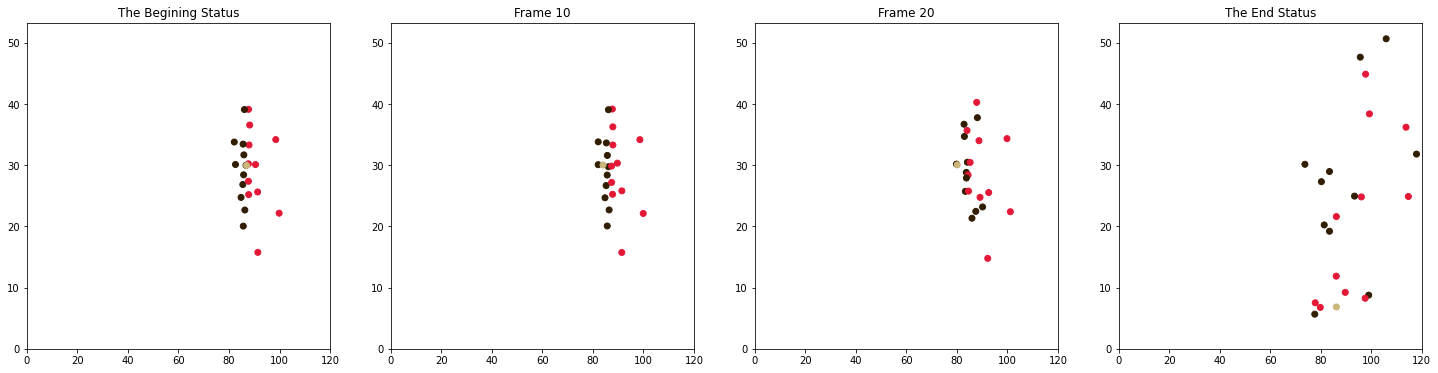

In [ ]:
# The red dots are KC players
# Balck dots are CLE players
# The light dot is the ball
# In this case they successfully give QB pressure
start_end(2021091209, 243)

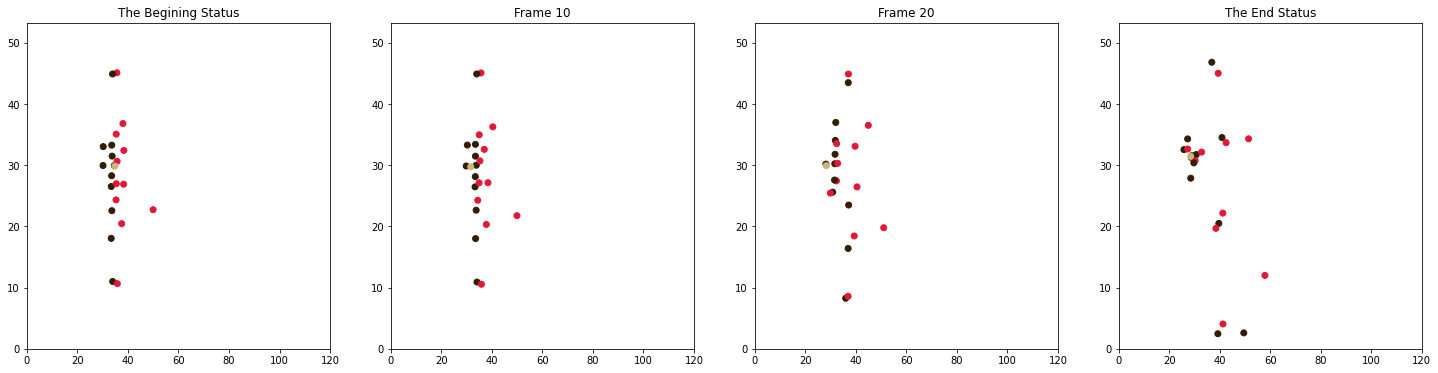

In [ ]:
# In this case they successfully give QB pressure
start_end(2021091209, 3149)

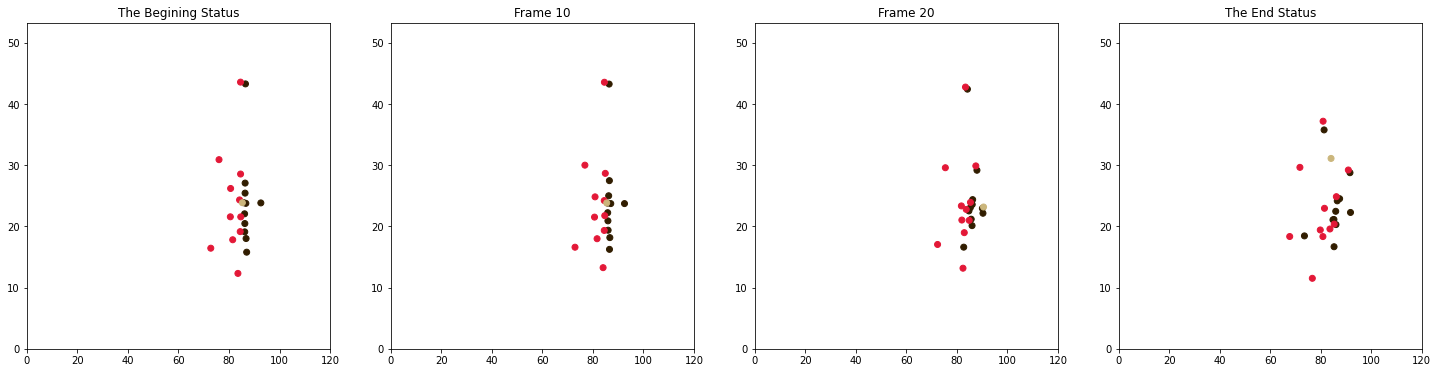

In [ ]:
# In this case they falied to give QB pressure
start_end(2021091209, 2833)

For KC's DL, they have an awful performance with 4 DL, 3 LB, 4 DB when facing 1 RB, 2 TE, 2 WR. They are 11% lower than the league average and only threaten the QB 7 times out of 28 times. From the picture above we can see that KC's DL can only give QB pressure when their lineman destroys the middle part of the offensive line. People not in the middle part of the scrimmage area were defending areas or other people. That may be because of their strategy setting or their lineman is not strong enough.